## Get Shapley values
This is a file to get mean absoulte shapley values over the whole set. Uses models obtained from xgBoostOptuna.ipynb.

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
#data = pd.read_feather("C:/Users/gard_/Documents/MasterThesis/ProjectThesis/MyPipeline/Data/Processed/wingBV_70k.feather")
#df = pd.read_csv('C:/Users/gard_/Documents/MasterThesis/ProjectThesis/MyPipeline/Data/CVfolds/cv_folds_wing_70k.csv')
#data_models = pd.read_csv("C:/Users/gard_/Documents/MasterThesis/ProjectThesis/MyPipeline/Models/shap_70k_params.csv")

In [3]:
mods = np.empty(10, dtype=object)

# Loop through each row to create and store the model
for i in range(len(data_models)):
    row = data_models.iloc[i]
    
    # Initialize the model with parameters from the current row
    model = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=row['learning_rate'],
        max_depth=int(row['max_depth']),  
        subsample=row['subsample'],
        colsample_bytree=row['colsample_bytree'],
        min_child_weight=int(row['min_child_weight'])
    )
    
    # Store the model in the numpy array
    mods[i] = model

In [31]:
X_CV = data.drop([
            "ID",
            "mean_pheno",
            "IID",
            "MAT",
            "PAT",
            "SEX",
            "PHENOTYPE",
            "hatchisland"
        ], axis = 1)

X_CV = X_CV.fillna(0)
# Change from float to int64 for all columns not 'ringnr' (i.e. all SNPs)
X_temp = X_CV.drop(['ringnr'], axis = 1)
X_temp = X_temp.T.astype('int64').T
X_temp.insert(0, 'ringnr', X_CV['ringnr'])
X_CV = X_temp

# y is ringnrs + pseudo phenotype
y_CV = data[['ID', 'ringnr']]

In [ ]:
shap_list = []
def get_shap():
    for i in range(1,11):
        print("Starting run ", i, "\n")
        test_idx = df[(df['Fold'] == i) & (df['Set'] == 'test')]['ringnr'].values
        train_val_idx = df[(df['Fold'] == i) & (df['Set'] == 'train')]['ringnr'].values
        X_train_val = X_CV[X_CV["ringnr"].isin(train_val_idx)].drop(["ringnr",],axis = 1)
        y_train_val = y_CV[y_CV['ringnr'].isin(train_val_idx)].drop(["ringnr",], axis = 1)
        X_test = X_CV[X_CV["ringnr"].isin(test_idx)].drop(["ringnr",], axis = 1)

        model = mods[i-1]
        model.fit(X_train_val, y_train_val, verbose = False)
        explainer = shap.TreeExplainer(model)
        shap_value = explainer.shap_values(X_test) # (n/10 x p)
        shap_list.append(shap_value)
    return(shap_list)

In [ ]:
# current_shap = pd.read_csv("C:/Users/gard_/Documents/MasterThesis/ProjectThesis/MyPipeline/Results/10shap_wing_70k.csv")

In [ ]:
# shap_list.append(current_shap)


In [88]:
shap_list = []
for i in range(1,11):
    name = str(i) + "shap_wing_70k.csv"
    temp_shap = pd.read_csv("C:/Users/gard_/Documents/MasterThesis/ProjectThesis/MyPipeline/Scrap/shap_wing_70k/" + name)
    shap_list.append(temp_shap)

In [ ]:
shap_list = get_shap() # (n x p)

Starting run  1 

Starting run  2 

Starting run  3 

Starting run  4 

Starting run  5 

Starting run  6 

Starting run  7 

Starting run  8 

Starting run  9 

Starting run  10 



In [60]:
# Now we have the mean of all shap values for each SNP
mean_shap = np.abs(np.concatenate(shap_list, axis=0)).mean(axis=0) # (p x 1), mean over the indvs
print(mean_shap.shape)

(65238,)


In [ ]:
# Ensure the mean_shap is a 1D array with shape (n_features,)
if mean_shap.ndim == 2:
    mean_shap = mean_shap.flatten()

# Save to be further manipulated in Chromosome2Manhattan.R
shap_df = pd.DataFrame(mean_shap.reshape(1,-1), columns=X_CV.drop(["ringnr"], axis = 1).columns) # (p x 1), Values for Manhattan

#feather.write_feather(shap_df, 'C:/Users/gard_/Documents/MasterThesis/ProjectThesis/MyPipeline/Results/shap_mass_70k.feather')

## Deviation vs \#SNPs plot

"Proportion of deviation" vs Amount of SNPs in descending order analysis is done below.

In [89]:
shap_values = np.concatenate(shap_list, axis=0) # (n x p)
print(shap_values.shape)

(3366, 65238)


Assuming n predictions and p covariates, giving $n \times p$ shapley values stored in $(n \times p)$ array. Intuition is this: For each individual prediction (each row of the matrix), the Shapley values **do not** sum to the deviation of this prediction from the **population** prediction mean. This is because we divide the individuals into 10 different test sets when calculating the shapley values. For each individual prediction, the Shapley values sum to the deviation of this prediction from the **test set** prediction mean, where it is specifically the test set that the individual was a part of.

This means that if we sum the absolute shapley values over all the individuals, the $(p\ \times\ 1)$ vector we get ("deviations" in the code below), **is not** the accumulated contributions of each shapley value to the deviation of population prediction mean. Thus, one of the advantages of Shapley values is lost by calculating them in 10 testsets. However, this $(p \times 1)$ vector that we get is a generally a good global approximation of the accumulated contributions of each shapley value to the deviation of population prediction mean. If the $(p\times 1)$ vector was a vector of "correctly" generated Shapley values, the sum of the elements (parameter "scale" given in the code below) would be equal to the sum of all the (absolute) prediction deviations from the population prediction mean. The value that we get by summing in our case is always (though really only a little) smaller than in the "correct" case (This can be proven by triangle inequality, see handwritten notes).

The question is then, is it useful to scale the "deviations" like given in the code below? The "scale" parameter in the code below tells us something about how variable the trait/predictions are. This information is lost if we scale by the "scale" factor. The scaled deviations **approximate** how much *proportional* contribution each SNP has to make the prediciton deviate from the prediction mean. Thus, it makes it easier to compare the contributions of SNPs across traits when we scale. To be clear: The question is if we want the y-axis of the plot to be 1 (scaled) or "equal" to the sum of the deviations from prediction mean.

In [146]:
shap_values = pd.read_feather("C:/Users/gard_/Documents/MasterThesis/ProjectThesis/MyPipeline/Results/shap_mass_70k.feather")

In [147]:
# shap_values is (n x p) vector of shapley values
# 1) Take absolute value of all Shapley values
# 2) Sum the Shapley values SHAP_j over all the indvs -> (p x 1) vector created
# 3) Put the accumulated Shapley values in descending order (Highest absolute value first)
deviations = -np.sort(-np.sum(np.abs(shap_values),axis = 0)) # (p x 1)
# Standardize deviations so that they sum to one?
scale = sum(deviations)
deviations = deviations/scale

In [148]:
# Adds contributions to devuation for each SNP, starting with biggest
cummulative_deviations = np.zeros(len(deviations))
temp = 0
for i in range(len(deviations)):
    temp += deviations[i]
    cummulative_deviations[i] = temp

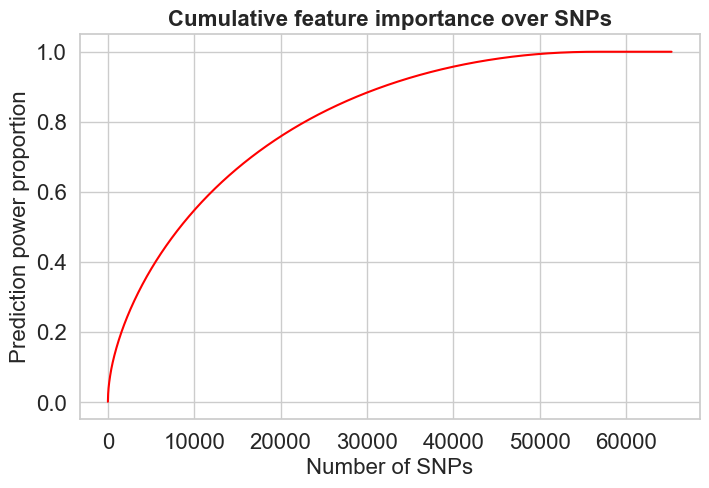

In [150]:
n_subset = len(deviations)
x = np.linspace(0, n_subset, n_subset)
data = pd.DataFrame({
    "Number of SNPs": x,
    "Proportion of deviation": cummulative_deviations[:n_subset]
})

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Create line plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=data, x="Number of SNPs", y="Proportion of deviation", color="red")
plt.title("Cumulative feature importance over SNPs", fontsize=16, weight="bold")
plt.xlabel("Number of SNPs", fontsize=16)
plt.ylabel("Prediction power proportion", fontsize=16)
plt.tick_params(axis='both', labelsize=16)

plt.savefig("C:/Users/gard_/Documents/MasterThesis/ProjectThesis/MyPipeline/Figures/mass_cumulative_deviations.pdf", dpi=300, bbox_inches="tight")
plt.show()

Plot the scaled deviations in descending order.

In [ ]:
n_subset = 800
#n_subset = len(variances)
x = np.linspace(0, n_subset, n_subset)
plt.figure(0)
plt.plot(x, deviations[0:n_subset], color = "red")
plt.xlabel("Number of SNPs")
plt.ylabel("Proportion of variance")
plt.show()

Testing some assumptions of the SHAP values.
Need the predictions for this analysis.

In [ ]:
#test_idx = df[(df['Fold'] == i) & (df['Set'] == 'test')]['ringnr'].values
#X_test = X_CV[X_CV["ringnr"].isin(test_idx)].drop(["ringnr",], axis = 1)
#predictions = model.predict(X_test)

Slice the shap_value such that it contains the prediction indvs.

In [ ]:
# Testing some assumptions of the model
print("Shape of shapley value array: ", shap_value.shape, "\n")
print("Shape of predictions array: ", predictions.shape, "\n")
# Mean of predictions:
mean_preds = sum(predictions)/len(predictions)

# The individual from the test set we will look at
indv = 17
# Sum over the shap-values for each SNP. These values should accumulate to the deviation from population mean
print(sum(shap_value[indv]), "\n")
# The deviation from population mean for the individual
print(predictions[indv] - mean_preds, "\n")

Manhattan plot of the shapley values.
Next up: Order by chromosome and base pair.

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0, len(shap_value[1]), len(shap_value[1]))
mean_shap = np.abs(shap_value).mean(axis = 0)
plt.figure(0)
plt.plot(x, mean_shap, 'bo', markersize = 1, color = "blue")
#plt.ylim(0.0,0.008)
plt.show()